In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib as mpl

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

# width = 234.8775 # in pt. \column
width = 487.8225 # in pt. \fullwidth
width, height = set_size(width, fraction=0.45) # in inch
print(width, height)

fontsize = 9
mpl.rcParams.update({
    "figure.figsize": (width, height), 
    "figure.facecolor": 'white', 
    "figure.edgecolor": 'white',
    "savefig.dpi": 360, 
    "figure.subplot.bottom": 0.5, 
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": fontsize-3,
    "xtick.labelsize": fontsize-2,
    "ytick.labelsize": fontsize-2,
    # tight layout,
    "figure.autolayout": True,
})

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

3.0375 1.877278240827806


In [2]:
# > 234.8775pt.
# l.164 Hello: \showthe\columnwidth
#                                   \showthe\textwidth

# > 487.8225pt.
# l.164 ...: \showthe\columnwidth \showthe\textwidth

In [3]:
path = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/dhb"

# PROBLEM ----
# problem = "loglin2"
problem = "navalpropulsion"

# PRUNER ----
# pruner = "CONST1"
pruner = "BCONST1"

# SEED ----
seed = 1914837113 

path = os.path.join(path, problem)
results_path = os.path.join(path, "output", f"dhb_{problem}-DBO1-{pruner}-200-{seed}", "results.csv")
df = pd.read_csv(results_path)
df

,p:activation_fn_1,p:activation_fn_2,p:batch_size,p:dropout_1,p:dropout_2,p:init_lr,p:lr_schedule,p:n_units_1,p:n_units_2,objective,job_id,rank,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val
0,tanh,relu,8,0.6,0.6,0.0005,cosine,16,128,-0.944693,0,0,0.095000,0.106815,1.674124e+09,1.674124e+09,1,True,-0.140622,-0.140832
1,relu,relu,32,0.3,0.0,0.0010,const,16,128,-0.941526,1,0,0.122283,0.127502,1.674124e+09,1.674124e+09,1,True,-0.489788,-0.490363
2,tanh,relu,64,0.0,0.0,0.0050,const,64,32,-0.568359,2,0,0.142294,0.147350,1.674124e+09,1.674124e+09,1,True,-0.001543,-0.001511
3,tanh,tanh,16,0.3,0.3,0.0010,const,256,256,-0.706693,3,0,0.162155,0.167557,1.674124e+09,1.674124e+09,1,True,-0.020030,-0.019920
4,relu,relu,16,0.0,0.0,0.0100,const,16,256,-0.393849,4,0,0.182175,0.187243,1.674124e+09,1.674124e+09,1,True,-0.009022,-0.008783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,relu,tanh,8,0.0,0.0,0.0100,const,512,512,-0.988720,195,0,31.839894,31.844662,1.674124e+09,1.674124e+09,1,True,-0.051528,-0.052919
196,relu,tanh,8,0.0,0.0,0.0005,const,512,256,-0.267132,196,0,32.015680,32.020316,1.674124e+09,1.674124e+09,1,True,-0.000712,-0.000724
197,relu,tanh,8,0.0,0.3,0.0005,const,512,512,-0.355303,197,0,32.191891,32.196557,1.674124e+09,1.674124e+09,1,True,-0.015130,-0.014915
198,tanh,tanh,16,0.0,0.0,0.0005,const,512,512,-0.411266,198,0,32.368856,32.373587,1.674124e+09,1.674124e+09,1,True,-0.001884,-0.001872


In [4]:
from collections import deque

def load_and_process(path, mode="max", topk_tournament=None, filter_duplicates=False):
    assert mode in ["min", "max"]
    df = pd.read_csv(path)
    
    if df.objective.dtype != np.float64:
        m = df.objective.str.startswith("F")
        df.loc[m,"objective"] = df.loc[m,"objective"].replace("F", "-1000000")
        df = df.astype({"objective": float})
        
    if mode == "min":
        df["objective"] = np.negative(df["objective"])
        if "m:objective_val" in df.columns:
            df["m:objective_val"] = np.negative(df["m:objective_val"])
        df["m:objective_test"] = np.negative(df["m:objective_test"])

    if topk_tournament:
        k = topk_tournament
        max_idx = []
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        for i in range(len(df)):
            fdf = df[:i+1]
            
            if filter_duplicates:
                fdf = fdf.drop_duplicates([pname for pname in df.columns if "p:" in pname], keep="last")
                
            if mode == "max":
                topk = fdf[:i+1].nlargest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nlargest(n=1, columns="m:objective_val")
            else:
                topk = fdf[:i+1].nsmallest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nsmallest(n=1, columns="m:objective_val")
                
            # consider that checkpointed "weights" can be reloaded
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100 - topk["m:budget"].sum()
            
            # consider that selected models are retrained from scratch
            df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100
            
            winner_idx = winner.index.tolist()[0]
            max_idx.append(winner_idx)
        
        df["max_idx"] = max_idx
        
    else:
        if mode == "max":
            df["objective_cummax"] = df["objective"].cummax()
        else:
            df["objective_cummax"] = df["objective"].cummin()
            
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        df["idx"] = df.index
        df = df.merge(df.groupby("objective_cummax")[["idx"]].first().reset_index(), on="objective_cummax")
        df.rename(columns={"idx_y": "max_idx"}, inplace=True)
        df.index  = df.idx_x.values
        del df["idx_x"]
        
        for idx in df["max_idx"]:
            if df.loc[idx, "m:budget"] < 100:
                df.loc[idx, "m:budget_cumsum"] = df.loc[idx, "m:budget_cumsum"] + 100
                
    return df

df = load_and_process(results_path, topk_tournament=3)
df

,p:activation_fn_1,p:activation_fn_2,p:batch_size,p:dropout_1,p:dropout_2,p:init_lr,p:lr_schedule,p:n_units_1,p:n_units_2,objective,...,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val,m:budget_cumsum,max_idx
0,tanh,relu,8,0.6,0.6,0.0005,cosine,16,128,-0.944693,...,0.095000,0.106815,1.674124e+09,1.674124e+09,1,True,-0.140622,-0.140832,101,0
1,relu,relu,32,0.3,0.0,0.0010,const,16,128,-0.941526,...,0.122283,0.127502,1.674124e+09,1.674124e+09,1,True,-0.489788,-0.490363,202,0
2,tanh,relu,64,0.0,0.0,0.0050,const,64,32,-0.568359,...,0.142294,0.147350,1.674124e+09,1.674124e+09,1,True,-0.001543,-0.001511,303,2
3,tanh,tanh,16,0.3,0.3,0.0010,const,256,256,-0.706693,...,0.162155,0.167557,1.674124e+09,1.674124e+09,1,True,-0.020030,-0.019920,304,2
4,relu,relu,16,0.0,0.0,0.0100,const,16,256,-0.393849,...,0.182175,0.187243,1.674124e+09,1.674124e+09,1,True,-0.009022,-0.008783,305,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,relu,tanh,8,0.0,0.0,0.0100,const,512,512,-0.988720,...,31.839894,31.844662,1.674124e+09,1.674124e+09,1,True,-0.051528,-0.052919,496,177
196,relu,tanh,8,0.0,0.0,0.0005,const,512,256,-0.267132,...,32.015680,32.020316,1.674124e+09,1.674124e+09,1,True,-0.000712,-0.000724,497,177
197,relu,tanh,8,0.0,0.3,0.0005,const,512,512,-0.355303,...,32.191891,32.196557,1.674124e+09,1.674124e+09,1,True,-0.015130,-0.014915,498,177
198,tanh,tanh,16,0.0,0.0,0.0005,const,512,512,-0.411266,...,32.368856,32.373587,1.674124e+09,1.674124e+09,1,True,-0.001884,-0.001872,499,177


## Average Test Objective w.r.t. Budget

### Comparing Early-Discarding Policies

In [50]:
stopper_label_mapping = {
    "NONE": "100-Epochs",
    "CONST4": "4-Epochs",
    "BCONST4": "4-Epochs",
    "BCONST1": "1-Epoch",
    "BMMF4": "LCE",
    "WPM": "WPM",
}

In [62]:
mode = "min"

# search = "RANDOM"
search = "DBO1"

problem = "navalpropulsion"
# problem = "parkinsonstelemonitoring"
# problem = "proteinstructure"
# problem = "slicelocalization"

seeds = [1608637542, 3421126067, 4083286876, 787846414, 3143890026, 3348747335, 2571218620, 2563451924, 670094950, 1914837113]

# pruners = ["BCONST1", "NONE", "SHA", "HB", "BMMF4", "WPM"]
# pruners = ["BCONST1", "NONE", "SHA", "HB", "BMMF4"]
pruners = ["BCONST1", "NONE", "SHA", "BMMF4"]
# pruners = ["NONE", "BMMF4", "WPM"]
# pruners = ["BCONST1", "FBCONST1"]

path = f"/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/dhb/{problem}"

all_path = {k:[] for k in pruners}
for p in pruners:
    for seed in seeds:
        path_i = os.path.join(path, "output", f"dhb_{problem}-{search}-{p}-200-{seed}", "results.csv")
        all_path[p].append(path_i)

# all_path

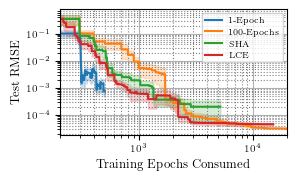

In [63]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

plt.figure()

for i, (label, path_list) in enumerate(all_path.items()):
    color = cmap(i)
    
    default_budget = 100
    x_space = np.arange(1, 200 * default_budget + 1)
    df_list = map(lambda p: load_and_process(p, mode=mode, topk_tournament=3 if "BCONST" in p else 1), path_list)
    x_max_i = 0
    y_list = []
    for i, df_i in enumerate(df_list):

        x = df_i["m:budget_cumsum"].to_numpy()
        x_max_i = max(x[-1], x_max_i)

        y = df_i.loc[df_i["max_idx"]]["m:objective_test"].values
        f = interp1d(x, y, kind="previous", fill_value="extrapolate")
        y = f(x_space)

        y_list.append(y)
        
    x = x_space[:x_max_i]
    y_list = np.asarray(y_list)
    y_list = y_list[:, :x_max_i]
    y_mean = y_list.mean(axis=0)
    y_stde = y_list.std(axis=0) / np.sqrt(len(y_list))

    plt.plot(x, y_mean, "-", color=color, label=stopper_label_mapping.get(label, label))
    plt.fill_between(x,
                     y_mean - y_stde,
                     y_mean + y_stde,
                     alpha=0.2,
                     color=color)
    
    # plt.axhline(y_mean[-1], linestyle="--", color=color, alpha=0.1)

plt.xlabel("Training Epochs Consumed")
plt.ylabel("Test RMSE")
# plt.ylabel("Objective")
plt.xscale("log")
# plt.xlim(100, 200 + 3*100)
plt.xlim(200, 100*200)
plt.yscale("log")
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.legend()
plt.savefig(f"pruners_{problem}_{search}.png", bbox_inches="tight")
plt.show()

### Comparing The Advantage of BO

In [118]:
mode = "min"

# searches = ["DBO1", "TPE-HB"]
# searches = ["DBO1", "DBO1-EI"]
searches = ["RANDOM", "DBO1", "TPE-HB"]

# problem = "navalpropulsion"
# problem = "parkinsonstelemonitoring"
# problem = "proteinstructure"
problem = "slicelocalization"

seeds = [1608637542, 3421126067, 4083286876, 787846414, 3143890026, 3348747335, 2571218620, 2563451924, 670094950, 1914837113]

pruner = "NONE"
# pruner = "BCONST1"
# pruner = "BMMF4"
# pruner = "CONST4"
# pruner = "SHA"
# pruner = "LOGLIN2"

path = f"/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/dhb/{problem}"

all_path = {k:[] for k in searches}
for search in searches:
    for seed in seeds:
        if search == "TPE-HB":
            path_i = os.path.join(path, "output", f"dhb_{problem}-{search}-200-{seed}", "results.csv")
        else:
            path_i = os.path.join(path, "output", f"dhb_{problem}-{search}-{pruner}-200-{seed}", "results.csv")
        all_path[search].append(path_i)

# search_label_mapping = {
#     "RANDOM": f"Random + {stopper_label_mapping.get(pruner, pruner)}",
#     "DBO1": f"BO + {stopper_label_mapping.get(pruner, pruner)}",
#     "TPE-HB": "TPE HB",
# }
search_label_mapping = {
    "RANDOM": "Random", #(RoBER)",
    "DBO1": "BO-RF", #(RoBER)",
    "TPE-HB": "BO-TPE", # (HB)",
}


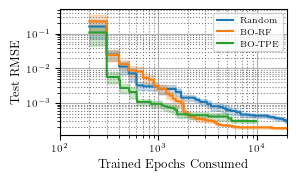

In [119]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

plt.figure()

for i, (label, path_list) in enumerate(all_path.items()):
    color = cmap(i)
    
    default_budget = 100
    x_space = np.arange(1, 200 * default_budget + 1)
    df_list = map(lambda p: load_and_process(p, mode=mode, topk_tournament=3 if "BCONST" in p else 1, filter_duplicates=True), path_list)
    x_max_i = 0
    y_list_obj = []
    y_list_test = []
    for i, df_i in enumerate(df_list):

        x = df_i["m:budget_cumsum"].to_numpy()
        x_max_i = max(x[-1], x_max_i)
        
        y = df_i.loc[df_i["max_idx"]]["m:objective_test"].values
        f = interp1d(x, y, kind="previous", fill_value="extrapolate")
        y = f(x_space)

        y_list_test.append(y)
        
        y = df_i.loc[df_i["max_idx"]]["objective"].values
        f = interp1d(x, y, kind="previous", fill_value="extrapolate")
        y = f(x_space)
        y_list_obj.append(y)
        
    x = x_space[:x_max_i]
    
    y_list_test = np.asarray(y_list_test)
    y_list_test = y_list_test[:, :x_max_i]
    y_mean_test = y_list_test.mean(axis=0)
    y_stde_test = y_list_test.std(axis=0) / np.sqrt(len(y_list_test))
    
    y_list_obj = np.asarray(y_list_obj)
    y_list_obj = y_list_obj[:, :x_max_i]
    y_mean_obj = y_list_obj.mean(axis=0)
    y_stde_obj = y_list_obj.std(axis=0) / np.sqrt(len(y_list_obj))

    # plt.plot(x, y_mean_obj, "--", color=color, label=search_label_mapping.get(label, label) + " (Valid)")
    plt.plot(x, y_mean_test, "-", color=color, label=search_label_mapping.get(label, label)) #+ " (Test)")
    plt.fill_between(x,
                     y_mean_test - y_stde_test,
                     y_mean_test + y_stde_test,
                     alpha=0.25,
                     color=color)

plt.xlabel("Trained Epochs Consumed")
plt.ylabel("Test RMSE")
# plt.ylabel("Objective")
plt.xlim(100,100*200)
# plt.xlim(100, 500)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.legend()
plt.tight_layout()
if "TPE-HB" in searches:
    plt.savefig(f"searches_{problem}_{pruner}_vs_tpehb.png")
else:
    plt.savefig(f"searches_{problem}_{pruner}.png")
plt.show()

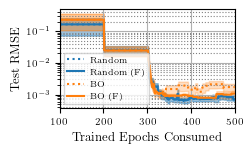

In [71]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

plt.figure()

for i, (label, path_list) in enumerate(all_path.items()):
    color = cmap(i)
    
    default_budget = 100
    x_space = np.arange(1, 200 * default_budget + 1)
    
    for filter_duplicates in [False, True]:
        df_list = map(lambda p: load_and_process(p, mode=mode, topk_tournament=3 if "BCONST" in p else 1, filter_duplicates=filter_duplicates), path_list)
        x_max_i = 0
        y_list_obj = []
        y_list_test = []
        for i, df_i in enumerate(df_list):

            x = df_i["m:budget_cumsum"].to_numpy()
            x_max_i = max(x[-1], x_max_i)

            y = df_i.loc[df_i["max_idx"]]["m:objective_test"].values
            f = interp1d(x, y, kind="previous", fill_value="extrapolate")
            y = f(x_space)

            y_list_test.append(y)

            # y = df_i.loc[df_i["max_idx"]]["objective"].values
            # f = interp1d(x, y, kind="previous", fill_value="extrapolate")
            # y = f(x_space)
            # y_list_obj.append(y)

        x = x_space[:x_max_i]

        y_list_test = np.asarray(y_list_test)
        y_list_test = y_list_test[:, :x_max_i]
        y_mean_test = y_list_test.mean(axis=0)
        y_stde_test = y_list_test.std(axis=0) / np.sqrt(len(y_list_test))

        # y_list_obj = np.asarray(y_list_obj)
        # y_list_obj = y_list_obj[:, :x_max_i]
        # y_mean_obj = y_list_obj.mean(axis=0)
        # y_stde_obj = y_list_obj.std(axis=0) / np.sqrt(len(y_list_obj))

        # plt.plot(x, y_mean_obj, "--", color=color, label=search_label_mapping.get(label, label) + " (Valid)")
        # plt.plot(x, y_mean_test, "-", color=color, label=search_label_mapping.get(label, label) + " (Test)")
        
        if not(filter_duplicates):
            plt.plot(x, y_mean_test, ":", color=color, label=search_label_mapping.get(label, label))
        else:
            plt.plot(x, y_mean_test, "-", color=color, label=search_label_mapping.get(label, label) + " (F)")
            
        plt.fill_between(x,
                         y_mean_test - y_stde_test,
                         y_mean_test + y_stde_test,
                         alpha=0.25,
                         color=color)

plt.xlabel("Trained Epochs Consumed")
plt.ylabel("Test RMSE")
# plt.ylabel("Objective")
# plt.xlim(100,100*200)
plt.xlim(100, 500)
plt.yscale("log")
# plt.xscale("log")
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.legend()
if "TPE-HB" in searches:
    plt.savefig(f"searches_{problem}_{pruner}_vs_tpehb_fd.png", bbox_inches="tight")
else:
    plt.savefig(f"searches_{problem}_{pruner}_fd.png", bbox_inches="tight")
plt.show()

### Bar Pots

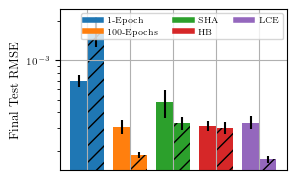

In [103]:
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

mode = "min"

# problem = "navalpropulsion"
# problem = "parkinsonstelemonitoring"
# problem = "proteinstructure"
problem = "slicelocalization"

seeds = [1608637542, 3421126067, 4083286876, 787846414, 3143890026, 3348747335, 2571218620, 2563451924, 670094950, 1914837113]

searches = ["RANDOM", "DBO1"]
pruners = ["BCONST1", "NONE", "SHA", "HB", "BMMF4"]

stopper_label_mapping = {
    "NONE": "100-Epochs",
    "CONST4": "4-Epochs",
    "BCONST4": "4-Epochs",
    "BCONST1": "1-Epoch",
    "BMMF4": "LCE",
    "WPM": "WPM",
}

path = f"/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/dhb/{problem}"

def get_data(search, pruner):
    if search == "DBO1" and pruner == "HB":
        search = "TPE"
    data = []
    for seed in seeds:
        path_i = os.path.join(path, "output", f"dhb_{problem}-{search}-{pruner}-200-{seed}", "results.csv")
        df = load_and_process(path_i, mode=mode, topk_tournament=3 if "BCONST" in pruner else 1)
        data.append(df)
    return data

# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

default_budget = 100
x_space = np.arange(1, 200 * default_budget + 1)

y_all = []
y_err_all = []
color_all = []

plt.figure()

for i, pruner in enumerate(pruners):
    color = cmap(i)
    
    for j, search in enumerate(searches):
        
        df_list = get_data(search, pruner)
        x_max_i = 0
        y_list = []
        for df_i in df_list:

            x = df_i["m:budget_cumsum"].to_numpy()
            x_max_i = max(x[-1], x_max_i)

            y = df_i.loc[df_i["max_idx"]]["m:objective_test"].values
            f = interp1d(x, y, kind="previous", fill_value="extrapolate")
            y = f(x_space)

            y_list.append(y)
        
        x = x_space[:x_max_i]
        y_list = np.asarray(y_list)
        y_list = y_list[:, :x_max_i]
        y_mean = y_list.mean(axis=0)
        y_stde = y_list.std(axis=0) / np.sqrt(len(y_list))

        y_all.append(y_mean[-1])
        y_err_all.append(y_stde[-1])
        color_all.append(color)
        
    
x = []
width = 0.8/len(searches)
hatches = []
for i, p in enumerate(pruners):
    x.append(i-width/2)
    x.append(i+width/2)
    hatches.append("")
    hatches.append("//")
    
@ticker.FuncFormatter
def major_formatter(x, pos):
    print(x, pos)
    return stopper_label_mapping.get(pruners[int(x)], pruners[int(x)])

plt.bar(x, y_all, yerr=y_err_all, color=color_all, width=width, hatch=hatches)

# plt.xlabel("Training Epochs Consumed")
plt.ylabel("Final Test RMSE")
# plt.ylabel("Objective")
# plt.xscale("log")
# plt.xlim(100, 200 + 3*100)
# plt.xlim(200, 100*200)
plt.yscale("log")
plt.grid()
# plt.grid(visible=True, which="minor", color="gray", linestyle=":")
# plt.legend()

handles = []
labels = []
for i, stopper in enumerate(pruners):
    h = mlines.Line2D([], [], color=cmap(i), linewidth=4, label=stopper_label_mapping.get(stopper, stopper))
    handles.append(h)
    labels.append(stopper_label_mapping.get(stopper, stopper))
plt.legend(handles=handles, ncols=3)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig(f"bar_pruner_with_bo_{problem}.png", bbox_inches="tight")
plt.show()